In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout,RandomFlip,RandomRotation,Activation
from keras.applications.vgg16 import VGG16
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import imghdr
import os
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

The below function checks the images in the data folder and removes images with extension other than jpg,jpeg and png

In [3]:
directory='data'
for cls in os.listdir(directory):
    for path in os.listdir(os.path.join(directory,cls)):
        img_path=os.path.join(directory,cls,path)
        img=cv2.imread(img_path)
        filetype=imghdr.what(img_path)
        if filetype not in ['jpg','jpeg','png']:
            os.remove(img_path)

<b>image_dataset_from_directory</b> function collects images from the folder, resizes the images of shape 256 x 256, creates batches and shuffles images. This function also takes care of creating labels for the images.

In [4]:
data=tf.keras.preprocessing.image_dataset_from_directory('data',batch_size=16)

Found 790 files belonging to 2 classes.


The above function returns a generator and we will convert it into a numpy iterator for iterating over batches

In [5]:
data_iterator=data.as_numpy_iterator()

In [11]:
## Returns a batch from the iterator
batch=data_iterator.next()

The iterator returns a tuple of 16(batch_size) images and their corresponding labels.

In [7]:
len(batch)

2

In [8]:
batch[0].shape

(16, 256, 256, 3)

In [9]:
batch[1]

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1])

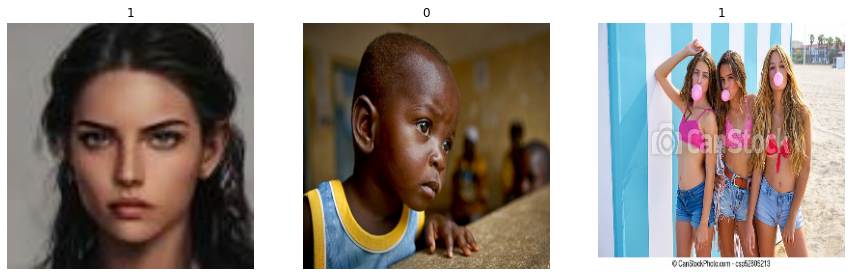

In [12]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,15))
for i,img in enumerate(batch[0][:3]):
    ax[i].imshow(img.astype('int'))
    ax[i].title.set_text(batch[1][i])
    ax[i].axis('off')

From the images above we can infer the labels of the image as:

<b>Male - 0
    
Female - 1</b>

### Preprocessing

In preprocessing we will clip our data to a range of 0-1 instead of 0-255. This helps our deepl learning model to generalize quickly.

In [13]:
data=tf.keras.preprocessing.image_dataset_from_directory('data',batch_size=16)
data=data.map(lambda x,y:(x/255,y)) ## This function clips pixels in the range of 0-1

Found 790 files belonging to 2 classes.


In [14]:
data_iterator=data.as_numpy_iterator()

In [17]:
batch=data_iterator.next()

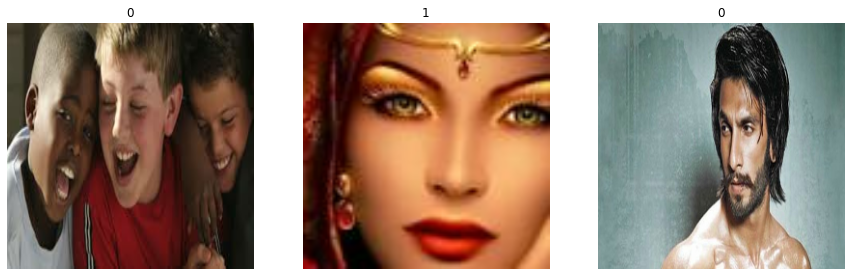

In [18]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,15))
for i,img in enumerate(batch[0][:3]):
    ax[i].imshow(img)
    ax[i].title.set_text(batch[1][i])
    ax[i].axis('off')

### Dataset split

Here we take 70% of data for training, 20% for validation and 10% for testing

In [29]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)+1
test_size=int(len(data)*0.1)

In [30]:
train_set=data.take(train_size)
val_set=data.skip(train_size).take(val_size)
test_set=data.skip(train_size+val_size).take(test_size)

## Building the model and training

In [78]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D())

# model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
# model.add(MaxPooling2D())

model.add(Flatten())

#model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [79]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 115200)          

In [80]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [81]:
callbacks_reduced_params=[
    keras.callbacks.ModelCheckpoint(filepath='model_reduced_parameters_bestweights2.h5',save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode=max,factor=0.05,patience=3)
]

In [97]:
history_reduced_params=model.fit(train_set,epochs=5,validation_data=val_set,callbacks=[callbacks_reduced_params])

Epoch 1/5
35/35 [==============================] - 108s 3s/step - loss: 0.1263 - accuracy: 0.9625 - val_loss: 0.5486 - val_accuracy: 0.8466
Epoch 2/5
35/35 [==============================] - 102s 3s/step - loss: 0.1388 - accuracy: 0.9500 - val_loss: 0.6084 - val_accuracy: 0.8295
Epoch 3/5
35/35 [==============================] - 96s 3s/step - loss: 0.1335 - accuracy: 0.9482 - val_loss: 0.8608 - val_accuracy: 0.8352
Epoch 4/5
35/35 [==============================] - 98s 3s/step - loss: 0.0766 - accuracy: 0.9804 - val_loss: 0.6461 - val_accuracy: 0.8580
Epoch 5/5
35/35 [==============================] - 98s 3s/step - loss: 0.0545 - accuracy: 0.9875 - val_loss: 0.9455 - val_accuracy: 0.8466


## Plotting training metrics

In [83]:
historyReducedParamsDF=pd.DataFrame(history_reduced_params.history)

In [84]:
fig=px.line(historyReducedParamsDF,y=historyReducedParamsDF.columns[1:4:2],title='Training accuracy vs Validation accuracy')
fig.update_layout(xaxis=dict(title='epochs'),
                 yaxis=dict(title='Loss'))

In [85]:
fig=px.line(historyReducedParamsDF,y=historyReducedParamsDF.columns[0:3:2],title='Training loss vs Validation loss')
fig.update_layout(xaxis=dict(title='epochs'),
                 yaxis=dict(title='Loss'))

### Model Evaluation

In [98]:
from keras.metrics import Precision,Recall,BinaryAccuracy

precision=Precision()
recall=Recall()
accuracy=BinaryAccuracy()

In [99]:
for x,y in test_set.as_numpy_iterator():
    yhat=model.predict(x)
    
    precision.update_state(y,yhat)
    recall.update_state(y,yhat)
    accuracy.update_state(y,yhat)

In [100]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 0.8148148059844971, Recall: 0.8148148059844971, Accuracy: 0.8177083134651184


## Prediction

In [149]:
yhat=0
def predict(img_path):
    img=cv2.imread(img_path)
    resized_image=cv2.resize(img,dim=(256,256))
    rescaled_image=resized_image/255.0
    yhat=model.predict(np.expand_dims(rescaled_image,0))
    label=''
    print(yhat.flatten()[0])
    if yhat<0.5:
        label='Male'
    else:
        label='Female'
    plt.imshow(rescaled_image)
    plt.axis('off')
    plt.title(label)

0.9961585


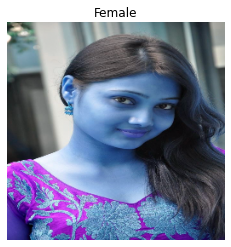

In [151]:
predict('45-455687_south-indian-teen-girls.jpg')